# Imports

In [1]:
import string
import nltk

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Data Loading to Dataframe & Overview

In [2]:
data=pd.read_csv("task1.csv")

In [3]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
data.shape

(50000, 2)

# Data Pre-Processing

In [5]:
#Encoding Categorical Data
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data['sentiment'] = data['sentiment'].astype('int')

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
data['review_clean'] = [BeautifulSoup(text).get_text() for text in data['review']] 
data['review_clean'] = data['review_clean'].apply(remove_punctuations)

In [8]:
stopwords = set(stopwords.words('english')) 
stemmer = nltk.stem.SnowballStemmer('english') 
index=0
str=' '
final_string=[]
s=''
for sent in data['review_clean'].values:
    filtered_sentence=[]
    for word in sent.split():
        if((word.isalpha()) & (len(word)>2)):    
            if(word.lower() not in stopwords):
                s=(stemmer.stem(word.lower()))
                #print(s)
                filtered_sentence.append(s)
            else:
                continue
        else:
            continue     
    str = " ".join(filtered_sentence)     
    final_string.append(str)
    index+=1

In [9]:
data['cleaned_review']=final_string
data['cleaned_review'].head()

0    one review mention watch episod youll hook rig...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: cleaned_review, dtype: object

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(data['cleaned_review'], data['sentiment'], test_size = 0.3, random_state = 42)



In [11]:
#TF_IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_train = tf_idf_vect.fit_transform(xtrain.values)
tf_idf_test = tf_idf_vect.transform(xtest.values)

# Hyperparameter Tuning

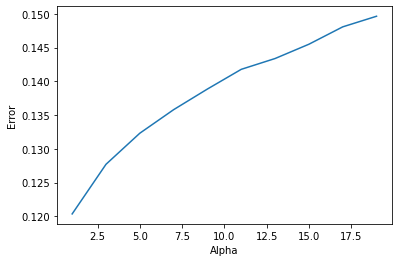

In [12]:
#Finding the optimal value of parameter alpha
alpha_range = list(np.arange(1,20,2))
alpha_scores=[]

for a in alpha_range:
    clf = MultinomialNB(alpha=a)
    scores = cross_val_score(clf, tf_idf_train, ytrain, cv=6, scoring='accuracy')
    alpha_scores.append(scores.mean())
MSE = [1 - x for x in alpha_scores]

optimal_alpha = alpha_range[MSE.index(min(MSE))]
plt.plot(alpha_range, MSE)

plt.xlabel('Alpha')
plt.ylabel('Error')
plt.show()

# Training Model Using Multinomial NBC

In [13]:
clf = MultinomialNB(alpha=optimal_alpha)
clf.fit(tf_idf_train,ytrain)

MultinomialNB(alpha=1)

# Model Evaluation on Training Data

In [14]:
y_pred_train = clf.predict(tf_idf_train)
acc_training = accuracy_score(ytrain, y_pred_train, normalize=True)
print('Training accuracy is: ', (acc_training))

cm_training = confusion_matrix(ytrain,y_pred_train)
tn_training = cm_training[0][0]
fn_training = cm_training[0][1]
fp_training = cm_training[1][0]
tp_training = cm_training[1][1]
actual_negative_training=tn_training+fp_training
actual_positive_training=fn_training+tp_training

precision_training=tp_training/(tp_training+fp_training)
print("Precision on Training",precision_training)
recall_training = tp_training/actual_positive_training
print("Recall on Training",recall_training)
f1_training = 2*((precision_training*recall_training)/(precision_training+recall_training))
print("f1-score on training",f1_training)

Training accuracy is:  0.9840571428571429
Precision on Training 0.9773131928091436
Recall on Training 0.9905116712264974
f1-score on training 0.983868169991327


# Model Evaluation on Testing Data

Test accuracy is:  0.8851333333333333


<AxesSubplot:>

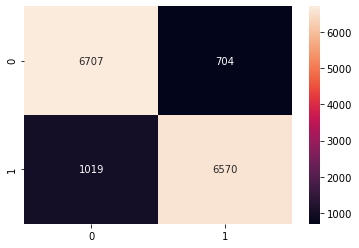

In [15]:
y_pred_test = clf.predict(tf_idf_test)
acc = accuracy_score(ytest, y_pred_test, normalize=True)#If False, return the number of correctly classified samples. Otherwise, return the fraction of correctly classified samples.
print('Test accuracy is: ',(acc))

cm_test = confusion_matrix(ytest,y_pred_test)
sns.heatmap(cm_test,annot=True,fmt='d')

In [16]:
precision, recall, fscore, support = score(ytest, y_pred_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))#number of occurrences of each class in y_true


precision: [0.86810769 0.90321694]
recall: [0.90500607 0.86572671]
fscore: [0.88617295 0.88407455]
support: [7411 7589]


Data Source: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews